In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pickle
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.stats import norm
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

In [11]:
class GittinsIndex:
    def __init__(self, Sigma, n, N = 20, xi = 3, delta = 0.02):
        self.Sigma = Sigma
        self.n = n
        self.mu = self.Sigma / self.n
        self.N = N
        self.xi = xi
        self.delta = delta
    
    
    def valueFunction(self, Lambda = 0):
        mid = math.ceil(self.xi * np.sqrt(1 / self.n) / self.delta)
        number_mu = mid * 2 + 1
        mu_plus = np.linspace(self.mu - mid * delta, self.mu + mid * delta, num = number_mu) 
    
        v = [[0] * number_mu for _ in range(self.N + 1)]
        
        lo = mu_plus - delta / 2
        hi = mu_plus + delta / 2

        value_vec_prev = np.zeros(number_mu)
        value_vec_curr = np.zeros(number_mu)
        
        for i in range(number_mu):
            v[-1][i] = mu_plus[i] - Lambda
            value_vec_prev[i] = max(mu_plus[i] - Lambda, 0)  # without discount
            

        for t in tqdm(reversed(range(0, self.N))):  # from N - 1 to 0
            t_n = t + self.n
            s = np.sqrt(1 / t_n + 1)   
            y_hi, y_lo = hi * (t_n + 1), lo * (t_n + 1)
    
            for j in reversed(range(number_mu)):
                yhi = y_hi - mu_plus[j] * t_n
                ylo = y_lo - mu_plus[j] * t_n
                p = norm.cdf(yhi, loc = mu_plus[j], scale = s) - norm.cdf(ylo, loc = mu_plus[j], scale = s)

                risk_reward = mu_plus[j] + (norm.cdf(ylo[0], loc = mu_plus[j], scale = s) * value_vec_prev[0] +
                              (1 - norm.cdf(yhi[-1], loc = mu_plus[j], scale = s)) * value_vec_prev[-1] +
                              np.dot(p, value_vec_prev))

                v[t][j] = risk_reward - Lambda
                
                if risk_reward > Lambda: 
                    value_vec_curr[j] = risk_reward - Lambda  # discount factor already computed for every iter
                else:
                    value_vec_curr[j] = 0
                
            value_vec_prev = value_vec_curr.copy()
            
        return v

In [12]:
class MultiArmedBandits:
    def __init__(self, k = 10, epsilon = 0, initial = 0, true_expected_reward = 0, step_size = None, ucb = None, 
                 gradient = None, baseline = None, thompson = None, bayes_ucb = None, gittins = None, 
                 num_steps = 1000, num_runs = 2000):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.initial_mu = true_expected_reward
        self.step_size = step_size
        self.ucb_c = ucb # degree of exploration
        self.gradient = gradient # step_size for gradient bandit algorithm
        self.baseline = baseline
        self.thompson = thompson
        self.bayes_ucb_c = bayes_ucb
        self.gi_values = gittins
        self.num_steps = num_steps
        self.num_runs = num_runs
        
        
    def new_bandit(self):
        self.q = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k).astype(int)
        self.mu = self.s1 * np.random.randn(self.k) + self.initial_mu  # s1: sd between arms
        self.action_optimal = np.argmax(self.mu)
        self.reward_episode = np.zeros(self.num_steps)
        self.action_episode = np.zeros(self.num_steps)
        if self.gradient:
            self.h = np.zeros(self.k)
            self.prev_rewards_bar = 0
            self.rewards_bar = 0
        if self.thompson or self.bayes_ucb_c:  # flat prior
            self.estimated_mu = np.zeros(self.k)
            self.estimated_var = np.zeros(self.k) + 1
        if self.gi_values != None:
            self.gi = np.zeros(self.k)
            self.idx = np.zeros(self.k).astype(int)

            
        
    # default: 1000 steps make up one episode/run    
    def episode(self):
        for step in range(self.num_steps):
            
            # choose action
            if np.random.random() < self.epsilon: # choose randomly
                action = np.random.randint(1,self.k)
            elif self.ucb_c:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    ucb_action = self.q + self.ucb_c * np.sqrt(np.divide(np.log(step + 1), self.action_count))
                    action = np.argmax(ucb_action)
            elif self.gradient: # gradient bandit: only consider numerical preference
                h_exp = np.exp(self.h)
                pi = h_exp / np.sum(h_exp)
                action = np.random.choice(np.arange(self.k), p = pi)
            elif self.thompson:
                samples = np.random.normal(self.estimated_mu, np.sqrt(self.estimated_var))
                action = np.random.choice(np.where(samples == max(samples))[0])
            elif self.bayes_ucb_c:
                self.q = norm.ppf(1 - 1 / ((step + 1) * pow(np.log(self.num_steps), self.bayes_ucb_c)), 
                                  self.estimated_mu, np.sqrt(self.estimated_var))
                action = np.random.choice(np.where(self.q == max(self.q))[0])
            elif self.gi_values != None:
                for i in range(self.k):
                    self.idx[i] = self.num_steps - 1 - step + self.action_count[i]
                    self.gi[i] = self.q[i] + self.gi_values[self.idx[i]][self.action_count[i]]
                action = np.random.choice(np.where(self.gi == max(self.gi))[0])
            else:
                action = np.argmax(self.q)  
            
            
            # update action
            self.action_count[action] += 1
            if action == self.action_optimal:
                self.action_episode[step] = 1

                
            # receive rewards
            reward = self.s2 * np.random.randn() + self.mu[action]  # s2: sd within a single arm
            self.reward_episode[step] = reward
            
            
            # update parameters
            if self.step_size:
                self.q[action] += self.step_size * (reward - self.q[action])  # constant step-size
            elif self.gradient:
                h_action = np.zeros(self.k)
                h_action[action] = 1
                if self.baseline: # if no baseline, q is constantly 0
                    self.rewards_bar += (reward - self.rewards_bar) / (step + 1) # average of all rewards
                self.h += self.gradient * (reward - self.rewards_bar) * (h_action - pi) # update h, eq. 2.12 stochastic gradient ascent              
            elif self.thompson or self.bayes_ucb_c:
                self.estimated_mu[action] += (reward - self.estimated_mu[action]) / (self.action_count[action] + 1)
                self.estimated_var[action] = 1 / (self.action_count[action] + 1)
            elif self.gi_values != None or self.bayes_ucb_c:
                self.q[action] += (reward - self.q[action]) / (self.action_count[action] + 1)  # sample average with N(0,1) prior
            else: 
                self.q[action] += (reward - self.q[action]) / self.action_count[action]  # sample average
        return self.reward_episode, self.action_episode
    
    # default: average of 2000 runs
    def simulate(self):
        average_reward = np.zeros((self.num_runs, self.num_steps))
        action_percentage = np.zeros((self.num_runs, self.num_steps))
        for run in tqdm(range(self.num_runs)):
            self.new_bandit()
            average_reward[run], action_percentage[run] = self.episode()
        return [np.mean(average_reward, axis = 0), np.mean(action_percentage, axis = 0), np.mean(average_reward, axis = 1)]

## horizon = n = 32, consider n + h = 0, ... , 32

In [91]:
gi_32_horizon = []
for N in tqdm(range(32)):  # remaining horizon h = N - n
    n = 1
    xi = 6
    delta = 0.001
    v = GittinsIndex(Sigma = 0, n = n, N = N, xi = xi, delta = delta).valueFunction(Lambda = 0)
    
    a = int(xi / delta / 2)
    roots = np.zeros(N + 1)
    for j in range(N):
        roots[j] = -fsolve(interp1d(np.linspace(-xi, xi, num = int(xi / delta) * 2 + 1)[a : -a], v[j][a : -a]), 0)
        
    gi_32_horizon.append(roots)

In [97]:
gi_32_horizon

[array([0.]),
 array([0.19518256, 0.        ]),
 array([0.32190691, 0.11268874, 0.        ]),
 array([0.4163582, 0.1892228, 0.079683 , 0.       ]),
 array([0.49180102, 0.2478516 , 0.13515649, 0.06172221, 0.        ]),
 array([0.55465576, 0.29557818, 0.17837013, 0.10537162, 0.05039603,
        0.        ]),
 array([0.60853828, 0.33590631, 0.21398337, 0.13976344, 0.08642462,
        0.04259247, 0.        ]),
 array([0.65569354, 0.37086172, 0.24436459, 0.16835547, 0.11504704,
        0.07328532, 0.03688605, 0.        ]),
 array([0.69761338, 0.40172712, 0.27089976, 0.19291733, 0.13899945,
        0.09782278, 0.0636295 , 0.03253062, 0.        ]),
 array([0.73534097, 0.42937008, 0.29447907, 0.21449403, 0.1596869 ,
        0.11846176, 0.08511456, 0.05622937, 0.0290961 , 0.        ]),
 array([0.7696348 , 0.45440526, 0.31570865, 0.2337586 , 0.17794075,
        0.13636341, 0.10326105, 0.07534524, 0.05037609, 0.0263186 ,
        0.        ]),
 array([0.80106394, 0.47728539, 0.33502331, 0.25117537

In [1]:
gittins_steps32_runs1000000 = MultiArmedBandits(gittins = gi_32_horizon, num_steps = 32, num_runs = 1000000).simulate()
thompson_steps32_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 32, num_runs = 1000000).simulate()


In [195]:
print("Gittins Index mean: " + str(np.mean(gittins_steps32_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps32_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps32_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps32_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 1.020111980366684
Gittins Index std: 0.0006415221708313003
Thompson Sampling mean: 0.7691286838148467
Thompson Sampling std: 0.0006210414461636757


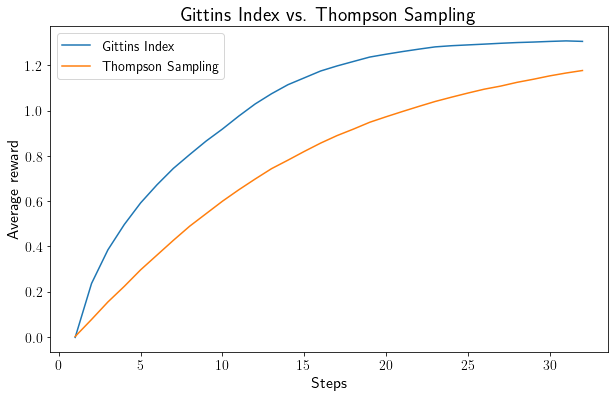

In [198]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

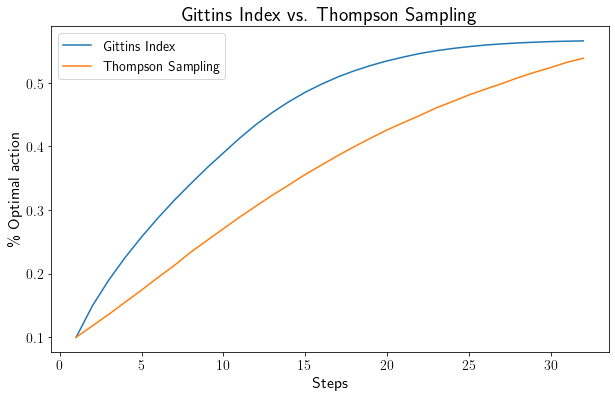

In [199]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()